## Modeling ##

In [2]:
import time
import pickle
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import Colormap
import scipy.stats as stats
from numpy import interp
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV, 
    cross_val_score, 
    cross_val_predict
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    r2_score,
    mean_squared_error, 
    root_mean_squared_error,
    mean_absolute_error, 
    mean_absolute_percentage_error,
    accuracy_score,
    matthews_corrcoef,
    brier_score_loss,
    f1_score,
    roc_curve, 
    roc_auc_score
)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.inspection import PartialDependenceDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
os.chdir('..')
print(f'Current working directory is {os.getcwd()}')

Current working directory is C:\Users\cavin\Documents\NSS_Projects\Python\big-g-big-rigs


This notebook is dedicated to the feature selection and statistical modeling of our trucking data.

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('data/data_clean_rows_dropped.csv', low_memory=False)

Cleaning features and reassigning them to the proper dtypes

In [6]:
columns_to_object = ['ecuSource',
                     'spn',
                     'fmi',
                     'MCTNumber',
                     'RecordID',
                     'ESS_Id'
                    ]

for column in columns_to_object:
    df[column] = df[column].astype(object)

In [7]:
columns_to_bool = ['CruiseControlActive',
                   'IgnStatus',
                   'ParkingBrake']

for column in columns_to_bool:
    df[column] = df[column].astype(bool)

In [8]:
int64_cols = df.select_dtypes(include='bool').columns
df[int64_cols] = df[int64_cols].astype('int64')

Separating the test and training data.

In [242]:
test_date = '2019-01-01'

df_test = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] > test_date]

In [10]:
df_train = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] < test_date]

In [11]:
#df = df.sample(frac=0.50)

Scaling and encoding features for modeling.

In [12]:
X_train = df_train.drop(columns = [
            'target',  
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'ecuSerialNumber',
            'ecuSoftwareVersion',
            'time_derate',
            'time_until_derate',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ServiceDistance',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'MCTNumber',
            'EquipmentID',
            'LampStatus',
            'AcceleratorPedal',
            'FuelLevel',
            'FuelTemperature',
            'ParkingBrake',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd',
            'ecuSource'
            ], axis=1)

y_train = df_train['target']

In [13]:
X_test = df_test.drop(columns = [
            'target',  
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'ecuSerialNumber',
            'ecuSoftwareVersion',
            'time_derate',
            'time_until_derate',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ServiceDistance',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'MCTNumber',
            'EquipmentID',
            'LampStatus',
            'AcceleratorPedal',
            'FuelLevel',
            'FuelTemperature',
            'ParkingBrake',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd',
            'ecuSource'
            ], axis=1)

y_test = df_test['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify = y_train, random_state = 27, train_size = 0.6/0.8)

Selection of features for each step of the pipeline. The last few lines are for checking to make sure each feature is accounted for.

In [14]:
ohe_features = ['spn',
                'fmi'
                ] 

bool_features = ['CruiseControlActive',
                 'IgnStatus',
                 'active'
                ]

scale_features = [
                  'BarometricPressure',
                  'EngineCoolantTemperature',
                  'EngineOilPressure',
                  'EngineOilTemperature',
                  'EngineRpm',
                  'activeTransitionCount',
                  'FuelLtd',
                  'IntakeManifoldTemperature',
                  'Speed',
                  'FuelRate',
                  'EngineTimeLtd',
                  'Throttle'
                ]

everything = list(set(ohe_features + bool_features + scale_features))
the_rest = X_train.columns.difference(everything)
# pca = PCA(n_components = 5)
the_rest

Index([], dtype='object')

In [14]:
%%time

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ii', IterativeImputer(initial_strategy = 'mean',
                           max_iter = 30,
                           sample_posterior = True))
])

categorical_pipeline = Pipeline([
    ('ohe', OneHotEncoder(categories='auto', 
                          handle_unknown = 'ignore')),
    ('si', SimpleImputer(strategy = 'most_frequent'))
])

boolean_pipeline = Pipeline([
    ('ii', IterativeImputer(initial_strategy = 'most_frequent',
                           max_iter = 30,
                           sample_posterior = True))
])

ct = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, scale_features),
        ('cat', categorical_pipeline, ohe_features),
        ('bool', boolean_pipeline, bool_features)
    ],
    remainder='drop'
)

pipe = Pipeline(
    steps=[
        ('transformer', ct)
    ])

pipe.fit(X_train, y_train)

CPU times: total: 2min 55s
Wall time: 1min 45s


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('ii',
                                                                   IterativeImputer(max_iter=30,
                                                                                    sample_posterior=True))]),
                                                  ['BarometricPressure',
                                                   'EngineCoolantTemperature',
                                                   'EngineOilPressure',
                                                   'EngineOilTemperature',
                                                   'EngineRpm',
                                                   'activeTransitionCount',
                                                   'FuelLtd',
                                                   'IntakeManifoldTemperature',
                                                   'Speed', 'FuelRate',
                                                   'EngineTimeLtd',
                                                   'Throttle']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('si',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['spn', 'fmi']),
                                                 ('bool',
                                                  Pipeline(steps=[('ii',
                                                                   IterativeImputer(initial_strategy='most_frequent',
                                                                                    max_iter=30,
                                                                                    sample_posterior=True))]),
                                                  ['CruiseControlActive',
                                                   'IgnStatus', 'active'])]))])

The above cell takes 4 minutes to fit the pipe, and the cell below takes 2 minutes to transform the pipe.

In [15]:
%%time

X_train_transformed = pipe.transform(X_train)
X_test_transformed = pipe.transform(X_test) 

CPU times: total: 7.11 s
Wall time: 6.88 s


In [16]:
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_transformed, y_train)

Transformation of pipe and saving the pipe as a pickle object so that the pipe doesn't need to be fitted again.

In [17]:
filename = 'pipe_transformed.pkl'

pickle_list = [pipe, X_train_balanced, X_test_transformed, y_train_balanced]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [15]:
filename = 'pipe_transformed.pkl'

with open(filename, 'rb') as file:
    pipe, X_train_balanced, X_test_transformed, y_train_balanced = pickle.load(file)

Applying the pipe transformations to models to see which model performs best.

%%time

knn_model = KNeighborsClassifier().fit(X_train_balanced, y_train_balanced)

%%time

y_pred_knn = knn_model.predict(X_test_transformed)

filename = 'knn.pkl'

pickle_list = [y_pred_knn, knn_model]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

filename = 'knn.pkl'

with open(filename, 'rb') as file:
    knn_model, y_pred_knn = pickle.load(file)

Prediction on KNeighborsClassifier takes a while

print(f'Accuracy: {accuracy_score(y_test, y_pred_knn)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_knn)}')
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, zero_division = 0))
#print(cross_val_score(knn_model, X_train_transformed, y_train, cv=3))

Cells below use hyperopt for hyperparameter tuning of xgboost

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf = xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']),
                    eval_metric="auc",
                    early_stopping_rounds=10)
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test_transformed, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(X_test_transformed)
    f1_score1 = f1_score(y_test, pred>0.5)
    print ("SCORE:", f1_score1)
    return {'loss': -f1_score1, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

In [19]:
%%time

xgbm = XGBClassifier(
    objective="binary:logistic",
    colsample_bytree = 0.9179993452534458,
    gamma = 3.55507468819673,
    max_depth = 17,
    min_child_weight = 9,
    reg_alpha = 62,
    n_estimators = 100,
    reg_lambda = 0.5990326545008506,
    scale_pos_weight = 1
).fit(X_train_balanced, y_train_balanced)

#y_pred_xgbm = xgbm.predict(X_test_transformed)

y_pred_proba = xgbm.predict_proba(X_test_transformed)[:, 1]

threshold = 0.7

y_pred_xgbm = (y_pred_proba > threshold).astype(int)

CPU times: total: 1min 22s
Wall time: 10.5 s


Cell below allowed for the feature importance graphing of scaled features, but is broken when all features are selected

xgbm.get_booster().feature_names = scale_features

plot_importance(xgbm)
plt.figure(figsize = (16, 12))
#plt.savefig("graphs/feature_importance.png")
plt.show();

In [20]:
filename = 'xgbm.pkl'

pickle_list = [y_pred_xgbm, xgbm]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [16]:
filename = 'xgbm.pkl'

with open(filename, 'rb') as file:
    y_pred_xgbm, xgbm = pickle.load(file)

In [17]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgbm)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_xgbm)}')
print(confusion_matrix(y_test, y_pred_xgbm))
print(classification_report(y_test, y_pred_xgbm, zero_division = 0))

Accuracy: 0.9916479280436877
MCC: 0.14868657311254738
[[55526   314]
 [  154    40]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     55840
           1       0.11      0.21      0.15       194

    accuracy                           0.99     56034
   macro avg       0.56      0.60      0.57     56034
weighted avg       0.99      0.99      0.99     56034



In [18]:
probas = xgbm.predict_proba(X_test_transformed)

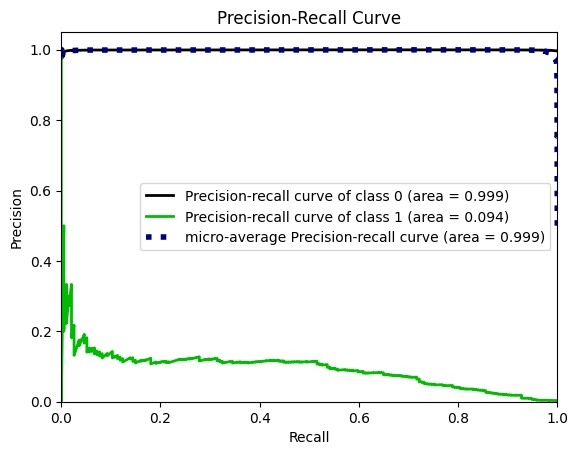

In [19]:
skplt.metrics.plot_precision_recall(y_test, probas)
#plt.savefig("graphs/precision_recall_curve.png")
plt.show()

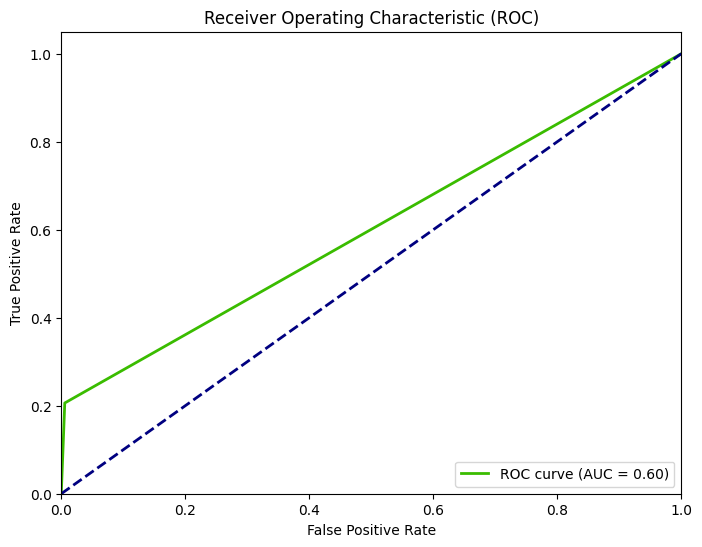

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgbm)
roc_auc = roc_auc_score(y_test, y_pred_xgbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#3ABC00', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
#plt.savefig("graphs/roc_curve.png")
plt.show();

In [248]:
df_test['predictions'] = y_pred_xgbm
df_test['EventTimeStamp'] = pd.to_datetime(df_test['EventTimeStamp'])
df_test['combined'] = df_test['target'].astype(str) + '_' + df_test['predictions'].astype(str)
df_test.groupby(['EquipmentID'])['combined'].value_counts().unstack(fill_value=0).drop_duplicates()

combined,0_0,0_1,1_0,1_1
EquipmentID,,,,
105338729,28,0,0,0
105344451,159,0,0,0
105349576,29,6,0,0
105370255,2,0,0,0
105427203,11,0,0,0
...,...,...,...,...
302,102,1,3,0
303,186,6,0,0
304,24,1,0,0


In [255]:
test_df = (
    (df_test[['EventTimeStamp', 'EquipmentID', 'target', 'predictions']]
     .sort_values(by=['EventTimeStamp', 'EquipmentID'])
 .groupby('EquipmentID')['EventTimeStamp']
 .diff().dt.total_seconds() / 3600)
# .isna()
# .value_counts()
)
test_df

353024           NaN
353025           NaN
353026           NaN
353027           NaN
353028      0.000000
             ...    
409053      0.623611
409054     21.137778
409055      0.946944
409056    264.845556
409057     78.453333
Name: EventTimeStamp, Length: 56034, dtype: float64

In [338]:
def target_pred(df, event, equipment, target, pred):
    df = df[[event, equipment, target]].copy()
    df['predict'] = pred
    df['combined'] = df[target].astype(str) + '_' + df['predict'].astype(str)
    df[event] = pd.to_datetime(df[event])
    df = df.sort_values(by=[equipment, event])

    df['time_diff'] = df.groupby(equipment)[event].diff().dt.total_seconds() / 3600
    df['valid_group'] = (df['time_diff'].isna()) | (df['time_diff'] <= 2)
    df['temp_group'] = (~df['valid_group']).cumsum()
    result = df.groupby([equipment, 'temp_group'])['combined'].value_counts().reset_index()
    result = df.groupby([equipment, 'temp_group'])['combined'].value_counts().unstack(fill_value=0).drop_duplicates()
    result = result.rename(columns = {'0_0': 'true negative', '0_1': 'false positive', '1_0': 'false negative', '1_1': 'true positive'})

    for index, row in result.iterrows():
        if row['true positive'] >= 1:
            result.loc[index, 'true positive'] = 1
            result.loc[index, ~result.columns.isin(['true positive'])] = 0
        elif row['true positive'] == 0 and row['false positive'] >= 1:
            result.loc[index, 'false positive'] = 1
            result.loc[index, ~result.columns.isin(['false positive', 'true positive'])] = 0
        elif row['true positive'] == 0 and row['false positive'] == 0 and row['false negative'] >= 1:
            result.loc[index, 'false negative'] = 1
            result.loc[index, ~result.columns.isin(['false negative', 'false positive', 'true positive'])] = 0
        else:
            result.loc[index, 'true negative'] = 1     

    counts = (result.iloc[:,0].sum() * 0) - (result.iloc[:,1].sum() * 500) - (result.iloc[:,2].sum() * 4000) + (result.iloc[:,3].sum() * 4000)
    return counts

In [339]:
pred_df = target_pred(df_test, 'EventTimeStamp', 'EquipmentID', 'target', y_pred_xgbm)
pred_df

np.int64(-13500)

In [150]:
%%time

rfc = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=27).fit(X_train_balanced, y_train_balanced)

y_pred_rfc = rfc.predict(X_test_transformed)

CPU times: total: 4.09 s
Wall time: 4.08 s


In [29]:
filename = 'rfc.pkl'

pickle_list = [y_pred_rfc, rfc]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [30]:
filename = 'rfc.pkl'

with open(filename, 'rb') as file:
    y_pred_rfc, rfc = pickle.load(file)

In [31]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_rfc)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_rfc)}')
print(confusion_matrix(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfc, zero_division = 0))

Accuracy: 0.8120962272905736
MCC: 0.10217054093936725
[[45336 10504]
 [   25   169]]
              precision    recall  f1-score   support

           0       1.00      0.81      0.90     55840
           1       0.02      0.87      0.03       194

    accuracy                           0.81     56034
   macro avg       0.51      0.84      0.46     56034
weighted avg       1.00      0.81      0.89     56034



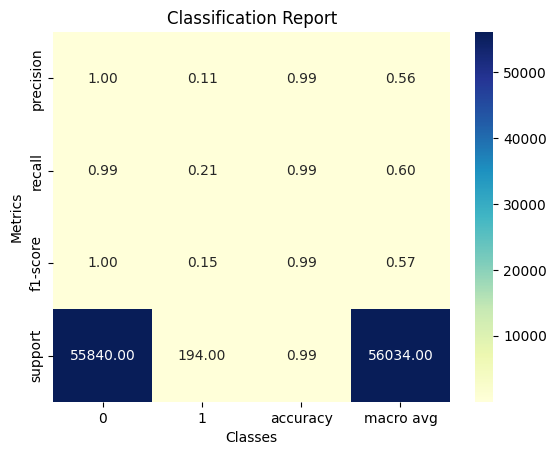

In [32]:
report = classification_report(y_test, y_pred_xgbm, output_dict=True)
df_report = pd.DataFrame(report).transpose()
    
fig, ax = plt.subplots()
sn.heatmap(df_report.iloc[:-1, :].T, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)

plt.title('Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
#plt.savefig("graphs/classification_report.png")
plt.show();

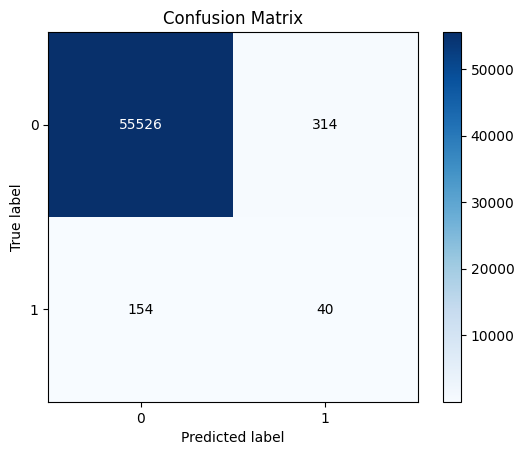

In [33]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_xgbm, normalize=False)
#plt.savefig("graphs/confusion_matrix.png")
plt.show()

In [34]:
%%time

logreg = LogisticRegression(max_iter=10000).fit(X_train_balanced, y_train_balanced)

y_pred_logreg = logreg.predict(X_test_transformed)

CPU times: total: 24.7 s
Wall time: 25.2 s


In [35]:
filename = 'logreg.pkl'

pickle_list = [y_pred_logreg, logreg]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [36]:
filename = 'logreg.pkl'

with open(filename, 'rb') as file:
    y_pred_logreg, logreg = pickle.load(file)

In [37]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_logreg)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_logreg)}')
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg, zero_division = 0))

Accuracy: 0.9185851447335547
MCC: 0.16622031675419616
[[51304  4536]
 [   26   168]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     55840
           1       0.04      0.87      0.07       194

    accuracy                           0.92     56034
   macro avg       0.52      0.89      0.51     56034
weighted avg       1.00      0.92      0.95     56034



In [38]:
df_test['predictions'] = y_pred_logreg

In [39]:
pred_df = df_test[['EventTimeStamp', 'EquipmentID', 'spn', 'target', 'predictions']]

In [40]:
pred_df[(pred_df['target'] == 1) & (pred_df['predictions'] == 1)].drop_duplicates()

,EventTimeStamp,EquipmentID,spn,target,predictions
355023,2019-01-13 11:58:11,1698,6802,1,1
355024,2019-01-13 11:58:11,1698,4340,1,1
355033,2019-01-13 13:13:23,1698,1569,1,1
356458,2019-01-21 03:54:10,1827,1569,1,1
356464,2019-01-21 04:38:44,1827,1569,1,1
...,...,...,...,...,...
406605,2020-02-13 08:32:46,1872,1569,1,1
406606,2020-02-13 08:32:46,1872,5743,1,1
406607,2020-02-13 08:32:46,1872,1761,1,1
406608,2020-02-13 08:32:46,1872,3364,1,1


y_val_pred_proba = pipe.predict_proba(X_val)[:,1]

candidate_thresholds = np.arange(start = 0.1, stop = 0.925, step = 0.01)
thresholds = pd.DataFrame({'threshold': candidate_thresholds})
thresholds['f1'] = thresholds['threshold'].apply(lambda x: f1_score(y_val, y_val_pred_proba > x))
thresholds.sort_values('f1', ascending = False).head()

threshold = 0.10

y_pred_proba = model.predict_proba(X_test_transformed)[:,1]

y_pred = y_pred_proba > threshold
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [41]:
target_pred(df_test, 'EventTimeStamp', 'EquipmentID', 'target', y_pred_logreg)

np.int64(-1120500)

In [42]:
#param_grid = {
#    'preprocessor__num__scaler__with_mean': [True, False],
#    'preprocessor__num__scaler__with_std': [True, False],
#    'classifier__C': [0.1, 1, 10],
#    'classifier__solver': ['liblinear', 'newton-cg']
#}

#randomized_search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=3)

%%time

hgbc = HistGradientBoostingClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_hgbc = hgbc.predict(X_test_transformed)

confusion_matrix(y_test, y_pred_hgbc)

print(classification_report(y_test, y_pred_hgbc, zero_division = 0))

In [43]:
%%time

dtc = DecisionTreeClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_dtc = dtc.predict(X_test_transformed)

CPU times: total: 2min 17s
Wall time: 2min 21s


In [44]:
filename = 'dtc.pkl'

pickle_list = [y_pred_dtc, dtc]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [45]:
filename = 'dtc.pkl'

with open(filename, 'rb') as file:
    y_pred_dtc, dtc = pickle.load(file)

In [46]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_dtc)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_dtc)}')
print(confusion_matrix(y_test, y_pred_dtc))
print(classification_report(y_test, y_pred_dtc, zero_division = 0))

Accuracy: 0.9896134489774066
MCC: 0.12508030928940583
[[55413   427]
 [  155    39]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     55840
           1       0.08      0.20      0.12       194

    accuracy                           0.99     56034
   macro avg       0.54      0.60      0.56     56034
weighted avg       0.99      0.99      0.99     56034



In [47]:
target_pred(df_test, 'EventTimeStamp', 'EquipmentID', 'target', y_pred_dtc)

np.int64(-282000)

%%time

svm = SVC(kernel='linear', C=1.0, gamma='auto', probability=True)

svm.fit(X_train_balanced, y_train_balanced)

y_pred_svm = svm.predict(X_test_transformed)

filename = 'svm.pkl'

pickle_list = [y_pred_svm, svm]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

filename = 'svm.pkl'

with open(filename, 'rb') as file:
    y_pred_svm, svm = pickle.load(file)

print(f'Accuracy: {accuracy_score(y_test, y_pred_svm)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_svm)}')
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division = 0))

In [48]:
%%time

lgb = LGBMClassifier().fit(X_train_balanced, y_train_balanced)

y_pred_lgb = lgb.predict(X_test_transformed)

[LightGBM] [Info] Number of positive: 352586, number of negative: 352586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.281444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21950
[LightGBM] [Info] Number of data points in the train set: 705172, number of used features: 240
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: total: 40.9 s
Wall time: 6.04 s


C:\Users\cavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [49]:
filename = 'lgb.pkl'

pickle_list = [y_pred_lgb, lgb]

with open(filename, 'wb') as file:
    pickle.dump(pickle_list, file)

In [50]:
filename = 'lgb.pkl'

with open(filename, 'rb') as file:
    y_pred_lgb, lgb = pickle.load(file)

In [51]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_lgb)}')
print(f'MCC: {matthews_corrcoef(y_test, y_pred_lgb)}')
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb, zero_division = 0))

Accuracy: 0.9846343291572973
MCC: 0.21680744133477553
[[55083   757]
 [  104    90]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     55840
           1       0.11      0.46      0.17       194

    accuracy                           0.98     56034
   macro avg       0.55      0.73      0.58     56034
weighted avg       1.00      0.98      0.99     56034



C:\Users\cavin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


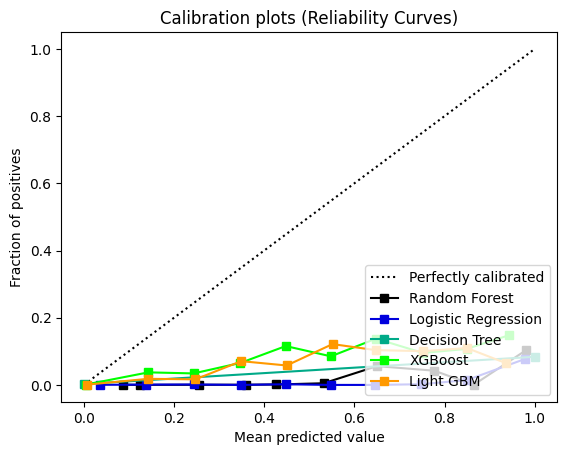

CPU times: total: 2.8 s
Wall time: 558 ms


In [52]:
%%time

rf_probas = rfc.predict_proba(X_test_transformed)
lr_probas = logreg.predict_proba(X_test_transformed)
dtc_probas = dtc.predict_proba(X_test_transformed)
xgbm_probas = xgbm.predict_proba(X_test_transformed)
lgb_probas = lgb.predict_proba(X_test_transformed)
probas_list = [rf_probas, 
               lr_probas, 
               dtc_probas, 
               xgbm_probas, 
               lgb_probas]
clf_names = ['Random Forest', 
             'Logistic Regression',
             'Decision Tree', 
             'XGBoost',
             'Light GBM']
skplt.metrics.plot_calibration_curve(y_test,
                                     probas_list,
                                     clf_names)
#plt.savefig("graphs/calibration_curve.png")
plt.show()

In [53]:
corr_matrix = X_train[scale_features].corr(numeric_only=True).melt(ignore_index=False)

In [54]:
corr_matrix[corr_matrix['value'] != 1].sort_values(by = 'value', ascending=False)

,variable,value
EngineCoolantTemperature,EngineOilTemperature,0.867195
EngineOilTemperature,EngineCoolantTemperature,0.867195
EngineOilPressure,EngineRpm,0.733898
EngineRpm,EngineOilPressure,0.733898
Speed,EngineRpm,0.729095
...,...,...
IntakeManifoldTemperature,Speed,-0.188566
activeTransitionCount,Speed,-0.241859
Speed,activeTransitionCount,-0.241859
IntakeManifoldTemperature,EngineOilPressure,-0.324065


In [55]:
X_train[scale_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 353024 entries, 0 to 353023
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   BarometricPressure         353020 non-null  float64
 1   EngineCoolantTemperature   353013 non-null  float64
 2   EngineOilPressure          353005 non-null  float64
 3   EngineOilTemperature       353010 non-null  float64
 4   EngineRpm                  353024 non-null  float64
 5   activeTransitionCount      353024 non-null  int64  
 6   FuelLtd                    352601 non-null  float64
 7   IntakeManifoldTemperature  353006 non-null  float64
 8   Speed                      353013 non-null  float64
 9   FuelRate                   353024 non-null  float64
 10  EngineTimeLtd              352539 non-null  float64
 11  Throttle                   313163 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 35.0 MB


In [56]:
plt.figure(figsize=(14, 9))
sn.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix')
#plt.savefig("graphs/corr_matrix.png")
plt.show()

ValueError: could not convert string to float: 'BarometricPressure'

<Figure size 1400x900 with 0 Axes>